In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import torch

### Set base parameters

In [2]:
# 設定訓練參數
max_length = 32
batch_size = 16
#batch_size = 32
learning_rate = 1e-4
num_epochs = 10

pad_index = 0
mask_index = 103
sep_index = 102
cls_index = 101
unk_index = 100

model_name = 'TF1_no_hanja_no_zy_zhtokenizer_v4'
dir_path = '.'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [71]:
dir_path = '.'


# Load data

## Read sentence for each ALIGNED article csv file with train set and test set.

In [3]:
df_train_transcript = pd.read_csv('{}/CORPUS/HANJA/HANJA_TRAIN_ALL.csv'.format(dir_path))
df_train_transcript = df_train_transcript.to_dict(orient='dict')

TRAIN_KSENT = (list(df_train_transcript['KO'].values()))
TRAIN_KSENT.remove('\"')

TRAIN_ZSENT = (list(df_train_transcript['ZH'].values()))
TRAIN_ZSENT.remove('”')

TRAIN_HSENT = (list(df_train_transcript['HANJA_Z'].values()))
TRAIN_HSENT.remove('\"')

#TRAIN_HSENT = (list(df_train_transcript['HANJA_K'].values()))
#TRAIN_HSENT.remove('\"')

print(len(TRAIN_KSENT))
df_train_transcript = []

146660


In [4]:
df_test_transcript = pd.read_csv('{}/CORPUS/HANJA/HANJA_TEST_ALL.csv'.format(dir_path))
df_test_transcript = df_test_transcript.to_dict(orient='dict')

TEST_KSENT = (list(df_test_transcript['KO'].values()))
TEST_ZSENT = (list(df_test_transcript['ZH'].values()))
TEST_HSENT = (list(df_test_transcript['HANJA_Z'].values()))
#TEST_HSENT = (list(df_test_transcript['HANJA_K'].values()))

df_test_transcript = []
print(len(TEST_KSENT))

36089


In [5]:
def find_delete_indexs(src_lists,dst_lists):
    delete_indexs = {}
    for i in range(len(src_lists)):
        if(len(src_lists[i]) < 3 or len(dst_lists[i]) < 3):
            delete_indexs[i] = 1
            #print(i,src_lists[i], dst_lists[i])
    return list(delete_indexs.keys())

1685 （掌聲） 박수
2315 不! 절대! 아닙니다!
6228 嗨。 안녕하세요.
6447 謝謝 감사합니다.!
9080 好! 알겠습니다.
10567 是的。 네.
11806 十？ 열 개? 우리는 질문해야 합니다.
11991 」 ”
13214 嗨。 안녕하세요.
14710 不。 아뇨.
31278 好。 좋아요.
33767 好。 좋습니다.
34090 什麼？ 뭐라
36726 不！ 아니죠.
39959 嗨！ 안녕하세요.
40878 你。 바로 여러분입니다.
46783 謝謝 감사합니다
51043 哇。 오우.
64302 好。 좋아요.
66859 」 " 저.. 회사의 관리자가 당신에게 심장 판막을 보내지 않기로 결정했습니다.
74805 人。 무언가는, 어 딘가는 언제나 변했을 겁니다.
76821 嗨！ 신발끈에도 패턴이 있기 때문입니다.
77330 在她於1917年過世時，這些夢想仍未實現。 ”
77331 」 감사합니다.
82234 摸。 이분은 조나 단이고 37세이며 석사 학위를 가지고 있습니다.
88883 因為和穆斯林結盟來對抗基督教夥伴所造成的憤怒讓他也失去了所有剩下的當地支援。 "
88884 」 다른 방법으로는 생각지도 못할 아이디어를 얻을 수 있습니다.
89997 好。 눈은 계속 감고 계시 고요 차이점을 들으셨나요?
93311 嗨。 제 수염이 반쪽만 있는 걸 눈치 채셨을 겁니다.
94843 透過讚美自由言論及讚頌平凡英雄，他的劇作讓觀眾在歡笑的同時也能有所思考。 "
94844 」 감사합니다.
98549 好。 모두 앉아 주세요.
100655 當時，我一直有修練松濤館空手道，從我有印象以來都在練，所以我已經拿了黑帶。 네.
101007 對？ ( 웃음) 이 시계의 무게는 기계적으로 조정되어서 계속해서 천천히 작동하도록 되어 있습니다.
105530 嗨！ ( 박수와 함성) 2020년 3월 이후로 사람들 보는 게 처음이에요.
108350 很多那些成功的男人都不喜歡聽到我說為什麼我不需要男朋友。 네.
110284 謝謝 그리고 우리가 다음에 가야 할 길을 방향 잡을 수 있을 것입니다.
113692 樹。 ( 긁는 소리) 이렇

In [ ]:
def delete_indexs_items(lists,delete_indexs):
    delete_indexs.reverse()
    for i in delete_indexs:
        del lists[i]
    return lists

In [ ]:
train_del_idxs = find_delete_indexs(TRAIN_ZSENT,TRAIN_KSENT)
TRAIN_ZSENT = delete_indexs_items(TRAIN_ZSENT,train_del_idxs)
TRAIN_KSENT = delete_indexs_items(TRAIN_KSENT,train_del_idxs)
TRAIN_HSENT = delete_indexs_items(TRAIN_HSENT,train_del_idxs)
TRAIN_ZYSENT = delete_indexs_items(TRAIN_ZYSENT,train_del_idxs)
print(len(TRAIN_ZSENT),len(TRAIN_KSENT),len(TRAIN_HSENT),len(TRAIN_ZYSENT))

In [6]:
test_del_idxs = find_delete_indexs(TEST_ZSENT,TEST_KSENT)
TEST_ZSENT = delete_indexs_items(TEST_ZSENT,test_del_idxs)
TEST_KSENT = delete_indexs_items(TEST_KSENT,test_del_idxs)
TEST_HSENT = delete_indexs_items(TEST_HSENT,test_del_idxs)
TEST_ZYSENT = delete_indexs_items(TEST_ZYSENT,test_del_idxs)
print(len(TEST_ZSENT),len(TEST_KSENT),len(TEST_HSENT),len(TEST_ZYSENT))

48
146660


In [163]:
print(TRAIN_ZYSENT[0])
print(TEST_ZYSENT[0])

ㄒㄧㄝˋㄒㄧㄝˋㄉㄚˋㄐㄧㄚ。
ㄨㄛˇㄒㄧㄤㄒㄧㄣˋㄖㄨˊㄍㄨㄛˇㄋㄧˇㄍㄟˇㄊㄚㄇㄣ˙ㄓㄥˋㄑㄩㄝˋㄉㄜ˙ㄈㄤㄈㄚˇㄏㄜˊㄍㄨㄥㄐㄩˋ，ㄊㄚㄇㄣ˙ㄎㄜˇㄧˇㄅㄚˇㄕㄢㄉㄡㄓㄨㄢˇㄧˊㄌㄜ˙ㄒㄧㄝˋㄒㄧㄝˋ（ㄍㄨˇㄓㄤˇㄕㄥ）


# Pretrain Model

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from torch.nn import Transformer

from transformers import BertTokenizer, BertModel, BertConfig, BertForPreTraining, AutoModel, BertTokenizerFast, BertForMaskedLM

import numpy as np
import matplotlib.pyplot as plt
import time
import math

## Load Tokenizer

In [13]:
import transformers
transformers.logging.set_verbosity_error() # solve the warning: 'Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.'

### Chinese Tokenizer

In [14]:
#zh_tokenizer = BertTokenizer.from_pretrained('{}/MODELS/TOKENIZER/new_zh_tokenizer_add_bpmf_korean_tokens_v2'.format(dir_path) )# load bert-base-chinese tokenizer with bpmf、hangul tokens(from 'kykim/bert-kor-base' and konlpy)
zh_tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

In [15]:
# zhuyin tokens
import re
zhuyins = ['ㄅ','ㄆ','ㄇ','ㄈ','ㄉ','ㄊ','ㄋ','ㄌ','ㄍ','ㄎ','ㄏ','ㄐ','ㄑ','ㄒ','ㄓ','ㄔ','ㄕ','ㄖ','ㄗ','ㄘ','ㄙ','ㄧ','ㄨ','ㄩ','ㄚ','ㄛ','ㄜ','ㄝ','ㄞ','ㄟ','ㄠ','ㄡ','ㄢ','ㄣ','ㄤ','ㄥ','ㄦ','ˇ','ˋ','ˊ','˙']

def check_bpmf_is_not(text):
    test_list = ['.*[ㄅㄆㄇㄈㄉㄊㄋㄌㄍㄎㄏㄐㄑㄒㄓㄔㄕㄖㄗㄘㄙㄧㄨㄩㄚㄛㄜㄝㄞㄟㄠㄡㄢㄣㄤㄥㄦˇˋˊ˙]+.*']
    for t in test_list:
        valid = re.compile(t)
        try:
            if(valid.match(text) != None):
                return True
        except:
            return False
    return False

zhuyin_df = pd.read_csv('{}/CORPUS/TOKEN/zhuyin_tokens_count.csv'.format(dir_path))
zhuyin_df = zhuyin_df.to_dict(orient='dict')
zhuyin_tokens = list(zhuyin_df['zhuyin'].values())
print(len(zhuyin_tokens))

for tok in zhuyin_tokens:
  if(check_bpmf_is_not(tok)):
    continue
  else:
    zhuyin_tokens.remove(tok)
print('zy:',len(zhuyins))
print('zy tokens:',len(zhuyin_tokens))

2751
zy: 41
zy tokens: 2089


In [16]:
# korean tokens
ko_tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
ko_tokenizer_tokens = list(ko_tokenizer.get_vocab().keys())
print(len(ko_tokenizer_tokens))

42000


In [17]:
# add new tokens
zh_tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
print('Original Length: ',len(zh_tokenizer))

zh_tokenizer.add_tokens(zhuyins)
print('Add zhuyins: ',len(zh_tokenizer))

zh_tokenizer.add_tokens(zhuyin_tokens)
print('Add zhuyin tokens: ',len(zh_tokenizer))

zh_tokenizer.add_tokens(ko_tokenizer_tokens)
print('Add korean tokens from kykim/bert-kor-base tokenizer: ',len(zh_tokenizer))

Original Length:  21128
Add zhuyins:  21146
Add zhuyin tokens:  22839
Add korean tokens from kykim/bert-kor-base tokenizer:  63662


In [18]:
zh_bert_model = AutoModel.from_pretrained('ckiplab/bert-base-chinese')
zh_bert_model.resize_token_embeddings(len(zh_tokenizer))

Embedding(63662, 768)

### Korean Tokenizer

In [25]:
ko_tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")

In [ ]:
ko_bert_model = BertModel.from_pretrained("kykim/bert-kor-base")

### mbert

In [25]:
mbert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [26]:
mbert_model = BertModel.from_pretrained('bert-base-multilingual-cased').to(device)
mbert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

### chinese bert with phonetic

In [19]:
my_model = zh_bert_model
my_model = my_model.to(device)
my_model.eval()

#tgt_model = zh_bert_model
my_tokenizer = zh_tokenizer
tgt_tokenizer = zh_tokenizer
model_name = 'TF1_no_hanja_no_zy_zhtokenizer_v7'

### Get Embeddings

In [27]:
# 输入文本
text = TEST_HSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = my_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = mbert_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

그러다 結局에는 그냥 屈伏下故 末乃 버리綿 적어도 多飮에는 아무 日 없을 거라고 生角하는 持經까지 이르렀습니다. 패배자可 된 느낌이었죠.
tensor([[[ 0.2751, -0.1491,  0.3304,  ..., -0.0059, -0.1405, -0.3108],
         [-0.1300, -0.3333,  1.0684,  ..., -0.2793, -0.3171, -0.4867],
         [ 0.2309, -0.4890,  0.1326,  ..., -0.0110, -0.2467, -0.8567],
         ...,
         [ 0.7320, -0.1392,  1.1718,  ...,  0.1636, -0.0037, -0.4018],
         [ 0.3692, -0.2858,  0.8215,  ...,  0.4665, -0.1487, -0.5134],
         [ 0.3086, -0.1198,  0.9983,  ...,  0.0486, -0.2033, -0.4707]]],
       device='cuda:0')


In [21]:
# 输入文本
text = TEST_HSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = zh_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = zh_bert_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

그러다 結局에는 그냥 屈伏下故 末乃 버리綿 적어도 多飮에는 아무 日 없을 거라고 生角하는 持經까지 이르렀습니다. 패배자可 된 느낌이었죠.
tensor([[[-0.3986, -0.2009,  0.2008,  ...,  0.4399,  0.4141,  0.4691],
         [ 0.0838, -0.1388, -0.5705,  ...,  0.7849,  1.0852, -0.0710],
         [-0.0747, -0.3994, -0.6897,  ...,  0.2100, -0.6700,  0.0048],
         ...,
         [ 0.0286, -0.2309, -0.4041,  ...,  0.2663,  0.4609, -0.2155],
         [-0.3307, -0.4798, -0.5780,  ...,  0.7395,  0.8964,  0.0967],
         [-0.3986, -0.2009,  0.2007,  ...,  0.4400,  0.4141,  0.4692]]],
       device='cuda:0')


In [80]:
# 输入文本
text = TEST_HSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = zh_tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length).to(device)

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = my_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state
print(embeddings.size())
print(embeddings)

embeddings = embeddings.permute(1,0,2)
print(embeddings.size())
    

print(embeddings)

그러다 結局에는 그냥 屈伏下故 末乃 버리綿 적어도 多飮에는 아무 日 없을 거라고 生角하는 持經까지 이르렀습니다. 패배자可 된 느낌이었죠.
torch.Size([1, 32, 768])
tensor([[[-0.2754, -0.2296,  0.3231,  ...,  0.1668, -0.0680,  0.7412],
         [-0.2662, -0.4697,  0.4225,  ...,  0.7963,  0.2854,  0.1497],
         [ 0.1149, -0.3635, -0.4776,  ..., -0.1523, -0.8024,  0.1329],
         ...,
         [-0.3369, -0.4975, -0.2277,  ...,  0.9826,  0.4889,  0.1550],
         [-0.2469, -0.1622, -0.1562,  ...,  0.6578,  0.1266,  0.3095],
         [-0.2754, -0.2296,  0.3231,  ...,  0.1669, -0.0680,  0.7412]]],
       device='cuda:0')
torch.Size([32, 1, 768])
tensor([[[-0.2754, -0.2296,  0.3231,  ...,  0.1668, -0.0680,  0.7412]],

        [[-0.2662, -0.4697,  0.4225,  ...,  0.7963,  0.2854,  0.1497]],

        [[ 0.1149, -0.3635, -0.4776,  ..., -0.1523, -0.8024,  0.1329]],

        ...,

        [[-0.3369, -0.4975, -0.2277,  ...,  0.9826,  0.4889,  0.1550]],

        [[-0.2469, -0.1622, -0.1562,  ...,  0.6578,  0.1266,  0.3095]],

        [[-0.2754, -0.2296, 

In [33]:
# 输入文本
print(TEST_ZSENT[923])
text = TEST_ZYSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = mbert_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
print(inputs['input_ids'])
print(mbert_tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))
# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = mbert_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

到最後我覺得，乾脆屈服熬過去，至少到下次再發生前我能得到點平靜。
ㄉㄠˋㄗㄨㄟˋㄏㄡˋㄨㄛˇㄐㄩㄝˊㄉㄜ˙，ㄍㄢㄘㄨㄟˋㄑㄩㄈㄨˊㄠˊㄍㄨㄛˋㄑㄩˋ，ㄓˋㄕㄠˇㄉㄠˋㄒㄧㄚˋㄘˋㄗㄞˋㄈㄚㄕㄥㄑㄧㄢˊㄨㄛˇㄋㄥˊㄉㄜ˙ㄉㄠˋㄉㄧㄢˇㄆㄧㄥˊㄐㄧㄥˋ。
tensor([[  101,   100, 10064,   100, 10064,   100,  1882,   102]],
       device='cuda:0')
， ， 。
tensor([[[ 0.1761,  0.2477,  0.2021,  ...,  0.0559,  0.0265,  0.0520],
         [-0.2596,  0.5538,  0.7481,  ...,  0.4942, -0.0487, -0.1889],
         [ 0.2373,  0.3286,  0.1775,  ...,  0.1499,  0.3106,  0.0685],
         ...,
         [-0.2755,  0.5195,  0.7319,  ...,  0.3360,  0.0062, -0.1785],
         [ 0.2210,  0.2828,  0.6919,  ...,  0.0976, -0.0144, -0.0212],
         [ 0.2256,  0.3239,  0.7765,  ...,  0.0071, -0.1020,  0.0957]]],
       device='cuda:0')


In [35]:
# 输入文本
print(TEST_ZSENT[923])
text = TEST_ZYSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = zh_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
print(inputs['input_ids'])
print(zh_tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = zh_bert_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

到最後我覺得，乾脆屈服熬過去，至少到下次再發生前我能得到點平靜。
ㄉㄠˋㄗㄨㄟˋㄏㄡˋㄨㄛˇㄐㄩㄝˊㄉㄜ˙，ㄍㄢㄘㄨㄟˋㄑㄩㄈㄨˊㄠˊㄍㄨㄛˋㄑㄩˋ，ㄓˋㄕㄠˇㄉㄠˋㄒㄧㄚˋㄘˋㄗㄞˋㄈㄚㄕㄥㄑㄧㄢˊㄨㄛˇㄋㄥˊㄉㄜ˙ㄉㄠˋㄉㄧㄢˇㄆㄧㄥˊㄐㄧㄥˋ。
tensor([[  101, 21212, 21314, 21222, 21160, 21298, 21178,  8024, 21847, 21669,
         21683, 21566, 22097, 21245, 21282,  8024, 21248, 21326, 21212, 21250,
         21176, 21159, 21463, 21158, 21164, 21160, 21293, 21178, 21212, 21330,
         21347, 21360,   511,   102]], device='cuda:0')
ㄉㄠˋ ㄗㄨㄟˋ ㄏㄡˋ ㄨㄛˇ ㄐㄩㄝˊ ㄉㄜ˙ ， ㄍㄢ ㄘㄨㄟˋ ㄑㄩ ㄈㄨˊ ㄠˊ ㄍㄨㄛˋ ㄑㄩˋ ， ㄓˋ ㄕㄠˇ ㄉㄠˋ ㄒㄧㄚˋ ㄘˋ ㄗㄞˋ ㄈㄚ ㄕㄥ ㄑㄧㄢˊ ㄨㄛˇ ㄋㄥˊ ㄉㄜ˙ ㄉㄠˋ ㄉㄧㄢˇ ㄆㄧㄥˊ ㄐㄧㄥˋ 。
tensor([[[ 0.6418,  0.2803, -0.6519,  ..., -0.0880,  0.3156,  0.0912],
         [ 0.1583,  0.7188, -0.5311,  ...,  0.6539,  0.5927, -0.4165],
         [ 0.4785,  0.4971, -0.8335,  ...,  1.1260,  0.9367, -0.4509],
         ...,
         [-0.1669, -0.0682, -1.1579,  ...,  0.9067,  0.4017, -0.5816],
         [ 0.3379,  0.3454,  0.3881,  ...,  0.5396, -0.3149,  0.3823],
         [ 0.6418,  0.2803, -0.6519,  ..., -0.0880,  0.3156,  0.0912]]],
       device='

## Build Dataset Function

In [ ]:
'''# 假設您有一個平行語料庫，這是您的資料集
class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences, hanja_sentences, bpmf_sentences):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences
        self.bpmf_sentences = bpmf_sentences
        self.hanja_sentences = hanja_sentences
        self.length = len(source_sentences)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        source = self.source_sentences[index]
        target = self.target_sentences[index]
        bpmf = self.bpmf_sentences[index]
        hanja = self.hanja_sentences[index]
        #print(index)
        return source, target, bpmf, hanja'''


In [23]:
# 假設您有一個平行語料庫，這是您的資料集
class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences
        self.length = len(source_sentences)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        source = self.source_sentences[index]
        target = self.target_sentences[index]
        
        source_token = my_tokenizer(source, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length)
        target_token = tgt_tokenizer(target, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length)

        
        
        #print(index)
        return source, target, source_token, target_token


### Data Loader

In [24]:
# 載入資料集
train_source_sentences = TRAIN_ZSENT  # 中文句子
train_target_sentences = TRAIN_KSENT  # 韓文句子
dataset = TranslationDataset(train_source_sentences, train_target_sentences)
#dataset = TranslationDataset(train_source_sentences, train_target_sentences, TRAIN_ZYSENT, TRAIN_HSENT)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [25]:
test_source_sentences = TEST_ZSENT  # 中文句子
test_target_sentences = TEST_KSENT  # 韓文句子
test_dataset = TranslationDataset(test_source_sentences, test_target_sentences)
#test_dataset = TranslationDataset(test_source_sentences, test_target_sentences, TEST_ZYSENT, TEST_HSENT)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [26]:
def get_pad_sequence(tokens,type_str):
    batch = [example[0] for example in tokens[type_str]]
    return  nn.utils.rnn.pad_sequence(batch, padding_value=pad_index)

In [27]:
start = time.time()
for batch in dataloader:
  #try:
        source, target, source_tokens, target_tokens  = batch
        #source_batch, target_batch , bpmf_batch , hanja_batch = batch
        #batch_src_ids = [example[0] for example in source_tokens['input_ids'] ]
        #batch_tgt_ids = [example[0] for example in target_tokens['input_ids']]
    
        #batch_src_ids = nn.utils.rnn.pad_sequence(batch_src_ids, padding_value=pad_index)
        #batch_tgt_ids = nn.utils.rnn.pad_sequence(batch_tgt_ids, padding_value=pad_index)
    
        #batch_src_attentions = [example[0] for example in source_tokens['attention_mask'] ]
        #batch_tgt_attentions = [example[0] for example in target_tokens['attention_mask']]
        
        #batch_src_attentions = nn.utils.rnn.pad_sequence(batch_src_attentions, padding_value=pad_index)
        #batch_tgt_attentions = nn.utils.rnn.pad_sequence(batch_tgt_attentions, padding_value=pad_index)
        '''
        batch_src_ids = get_pad_sequence(source_tokens,type_str='input_ids')
        batch_tgt_ids = get_pad_sequence(target_tokens,type_str='input_ids')
        batch_src_attentions = get_pad_sequence(source_tokens,type_str='attention_mask')
        batch_tgt_attentions = get_pad_sequence(target_tokens,type_str='attention_mask')
        '''
        #print('batch_src_ids',batch_src_ids)
        #print('batch_tgt_ids',batch_tgt_ids)
        #print('batch_src_attentions', batch_src_attentions)
        #print('batch_tgt_attentions', batch_tgt_attentions)
        #break
  #except:
  #      print('ERROR')
  #      break
end = time.time()
print(int((end-start)/60),'m',(end-start)%60,'s')

0 m 28.194465160369873 s


In [28]:
start = time.time()
for batch in test_dataloader:
  #try:
        source, target, source_tokens, target_tokens  = batch
        #source_batch, target_batch , bpmf_batch , hanja_batch = batch
        #batch_src_ids = [example[0] for example in source_tokens['input_ids'] ]
        #batch_tgt_ids = [example[0] for example in target_tokens['input_ids']]
    
        #batch_src_ids = nn.utils.rnn.pad_sequence(batch_src_ids, padding_value=pad_index)
        #batch_tgt_ids = nn.utils.rnn.pad_sequence(batch_tgt_ids, padding_value=pad_index)
    
        #batch_src_attentions = [example[0] for example in source_tokens['attention_mask'] ]
        #batch_tgt_attentions = [example[0] for example in target_tokens['attention_mask']]
        
        #batch_src_attentions = nn.utils.rnn.pad_sequence(batch_src_attentions, padding_value=pad_index)
        #batch_tgt_attentions = nn.utils.rnn.pad_sequence(batch_tgt_attentions, padding_value=pad_index)
        '''
        batch_src_ids = get_pad_sequence(source_tokens,type_str='input_ids')
        batch_tgt_ids = get_pad_sequence(target_tokens,type_str='input_ids')
        batch_src_attentions = get_pad_sequence(source_tokens,type_str='attention_mask')
        batch_tgt_attentions = get_pad_sequence(target_tokens,type_str='attention_mask')
        '''
        #print('batch_src_ids',batch_src_ids)
        #print('batch_tgt_ids',batch_tgt_ids)
        #print('batch_src_attentions', batch_src_attentions)
        #print('batch_tgt_attentions', batch_tgt_attentions)
        #break
  #except:
  #      print('ERROR')
  #      break
end = time.time()
print(int((end-start)/60),'m',(end-start)%60,'s')

0 m 6.917654991149902 s


## Build Model

### Set transformer parameter

In [29]:
src_vocab_size = len(my_tokenizer)
tgt_vocab_size = len(tgt_tokenizer)
embed_size = 768
ffn_hid_dim = 256
num_heads = 8
num_layers = 6

num_encoder_layers = 3
num_decoder_layers = 3

pad_index = 0
mask_index = 103
sep_index = 102
cls_index = 101
unk_index = 100

In [27]:
special_tokens = ['[CLS]','[MASK]','[PAD]','[SEP]','[UNK]']
for ids in my_tokenizer(special_tokens)['input_ids']:
  print(ids , my_tokenizer.decode(ids))

[101, 101, 102] [CLS] [CLS] [SEP]
[101, 103, 102] [CLS] [MASK] [SEP]
[101, 0, 102] [CLS] [PAD] [SEP]
[101, 102, 102] [CLS] [SEP] [SEP]
[101, 100, 102] [CLS] [UNK] [SEP]


### Initialize Model

In [28]:
'''class TranslationModel(nn.Module):
    def __init__(self, bert_model, vocab_size, embed_size, num_heads, num_layers, max_length):
        super(TranslationModel, self).__init__()
        self.embedding = bert_model
        self.position_embedding = nn.Embedding(max_length, embed_size)
        self.transformer = nn.Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers
        )
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, src, tgt, attention_mask, src_mask=None, tgt_mask=None, memory_mask=None):
    #def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None, attention_mask, hanja_ids, hanja_attention_mask, bpmf_ids, bpmf_attention_mask):
        src_seq_length = src.size(0)
        tgt_seq_length = tgt.size(0)
        print('src_seq_length:',src_seq_length)

        src_pos = torch.arange(0, src_seq_length).unsqueeze(1).to(device)
        tgt_pos = torch.arange(0, tgt_seq_length).unsqueeze(1).to(device)

        src = self.embedding(src).last_hidden_state + self.position_embedding(src_pos)
        tgt = self.embedding(tgt).last_hidden_state + self.position_embedding(tgt_pos)

        memory = self.transformer.encoder(src, src_key_padding_mask=src_mask)
        out = self.transformer.decoder(tgt, memory, tgt_key_padding_mask=tgt_mask, memory_key_padding_mask=memory_mask)
        out = self.fc(out)

        return out'''

"class TranslationModel(nn.Module):\n    def __init__(self, bert_model, vocab_size, embed_size, num_heads, num_layers, max_length):\n        super(TranslationModel, self).__init__()\n        self.embedding = bert_model\n        self.position_embedding = nn.Embedding(max_length, embed_size)\n        self.transformer = nn.Transformer(\n            d_model=embed_size,\n            nhead=num_heads,\n            num_encoder_layers=num_layers,\n            num_decoder_layers=num_layers\n        )\n        self.fc = nn.Linear(embed_size, vocab_size)\n\n    def forward(self, src, tgt, attention_mask, src_mask=None, tgt_mask=None, memory_mask=None):\n    #def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None, attention_mask, hanja_ids, hanja_attention_mask, bpmf_ids, bpmf_attention_mask):\n        src_seq_length = src.size(0)\n        tgt_seq_length = tgt.size(0)\n        print('src_seq_length:',src_seq_length)\n\n        src_pos = torch.arange(0, src_seq_length).unsqueeze(

In [44]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, bert_model, src_vocab_size: int = src_vocab_size, tgt_vocab_size: int = tgt_vocab_size, emb_size = embed_size, dropout_prob = 0.1):
        super(TokenEmbedding, self).__init__()
        #self.embedding = bert_model
        self.emb_size = emb_size
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_ids, attention_mask):
        #print('embedding size:',self.embedding(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state.size())
        embed = my_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        #output = embed * math.sqrt(self.emb_size)
        output = self.dropout(embed)
        return output

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 bert_model,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(bert_model)
        self.tgt_tok_emb = TokenEmbedding(bert_model)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self,
                src_input_ids, src_attention_mask,
                tgt_input_ids, tgt_attention_mask,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor=None):
        #src_emb = self.positional_encoding(self.src_tok_emb(src_input_ids, src_attention_mask))
        src_emb = self.src_tok_emb(src_input_ids, src_attention_mask)
        src_emb = src_emb.permute(1,0,2)#.contiguous()
        #print('src_emb (no_positional):',src_emb)
        
        src_emb = self.positional_encoding(src_emb)
        #print('src_emb (after_positional):',src_emb)
        #tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt_input_ids, tgt_attention_mask))
        tgt_emb = self.tgt_tok_emb(tgt_input_ids, tgt_attention_mask)
        tgt_emb = tgt_emb.permute(1,0,2)#.contiguous()
        #print('tgt_emb (no_positional):',tgt_emb)
        tgt_emb = self.positional_encoding(tgt_emb)
        #print('tgt_emb (after_positional):',tgt_emb)
        #src_mask = src_mask.permute(1,0)
        #tgt_mask = tgt_mask.permute(1,0)
        #src_padding_mask = src_padding_mask.permute(1,0)
        #tgt_padding_mask = tgt_padding_mask.permute(1,0)
        #print('src_mask = ',src_mask)
        #print('tgt_mask = ',tgt_mask)
        #print('src_padding_mask = ',src_padding_mask)
        #print('tgt_padding_mask = ',tgt_padding_mask)
        
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        #print('outs (in model):',outs)
        return self.generator(outs)

    def encode(self, src_input_ids, src_attention_mask, src_mask: Tensor):
        #return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src_input_ids, src_attention_mask)), src_mask)
        src_emb = self.src_tok_emb(src_input_ids, src_attention_mask).permute(1,0,2)#.contiguous()
        #print('encode size:',src_emb.size())
        return self.transformer.encoder(self.positional_encoding(src_emb), src_mask.permute(1,0))

    def decode(self, tgt_input_ids, tgt_attention_mask, memory: Tensor, tgt_mask: Tensor):
        tgt_emb = self.tgt_tok_emb(tgt_input_ids, tgt_attention_mask)#.contiguous()
        #print('decode_size:',tgt_emb.size())
        #print('memory_size',memory.size())
        return self.transformer.decoder(self.positional_encoding(tgt_emb), memory,tgt_mask.permute(1,0))
        #return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt_input_ids, tgt_attention_mask)), memory,tgt_mask)

In [45]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src = src.permute(1,0)
    tgt = tgt.permute(1,0)
    #print('src',src.size())
    #print('tgt',tgt.size())
    try:
        src_seq_len = src.shape[0]
        tgt_seq_len = tgt.shape[0]
    except:
        src_seq_len = max_length
        tgt_seq_len = max_length
        

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == pad_index).transpose(0, 1)
    tgt_padding_mask = (tgt == pad_index).transpose(0, 1)
    #print('src_padding_mask',src_padding_mask.size())
    #print('tgt_padding_mask',tgt_padding_mask.size())
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [46]:
torch.manual_seed(0)

transformer = Seq2SeqTransformer(my_model, num_encoder_layers, num_decoder_layers, embed_size,
                                 num_heads, src_vocab_size, tgt_vocab_size, ffn_hid_dim)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = transformer.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [71]:
'''class TranslationModel(nn.Module):
    def __init__(self, bert_model, dropout_prob=0.1):
        super(TranslationModel, self).__init__()
        self.bert1 = bert_model
        #self.bert2 = bert_model
        self.bert3 = bert_model
        self.dropout1 = nn.Dropout(dropout_prob)
        #self.dropout2 = nn.Dropout(dropout_prob)
        self.dropout3 = nn.Dropout(dropout_prob)
        self.linear = nn.Linear(self.bert1.config.hidden_size, len(tgt_tokenizer))

    def forward(self, input_ids, hanja_ids, attention_mask, hanja_attention_mask, bpmf_ids, bpmf_attention_mask):
        zh_outputs = self.bert1(input_ids=input_ids, attention_mask=attention_mask)
        #bpmf_outputs = self.bert2(input_ids=bpmf_ids, attention_mask=bpmf_attention_mask)
        hanja_outputs = self.bert3(input_ids=hanja_ids, attention_mask=hanja_attention_mask)

        # Apply dropout
        zh_outputs = self.dropout1(zh_outputs.last_hidden_state)
        #bpmf_outputs = self.dropout2(bpmf_outputs.last_hidden_state)
        hanja_outputs = self.dropout3(hanja_outputs.last_hidden_state)

        # Combine representations
        combined_outputs = 0.5 * zh_outputs + 0.5 * hanja_outputs # + 0.25 * bpmf_outputs

        prediction_scores = self.linear(combined_outputs)
        return prediction_scores'''


'class TranslationModel(nn.Module):\n    def __init__(self, bert_model, dropout_prob=0.1):\n        super(TranslationModel, self).__init__()\n        self.bert1 = bert_model\n        #self.bert2 = bert_model\n        self.bert3 = bert_model\n        self.dropout1 = nn.Dropout(dropout_prob)\n        #self.dropout2 = nn.Dropout(dropout_prob)\n        self.dropout3 = nn.Dropout(dropout_prob)\n        self.linear = nn.Linear(self.bert1.config.hidden_size, len(tgt_tokenizer))\n\n    def forward(self, input_ids, hanja_ids, attention_mask, hanja_attention_mask, bpmf_ids, bpmf_attention_mask):\n        zh_outputs = self.bert1(input_ids=input_ids, attention_mask=attention_mask)\n        #bpmf_outputs = self.bert2(input_ids=bpmf_ids, attention_mask=bpmf_attention_mask)\n        hanja_outputs = self.bert3(input_ids=hanja_ids, attention_mask=hanja_attention_mask)\n\n        # Apply dropout\n        zh_outputs = self.dropout1(zh_outputs.last_hidden_state)\n        #bpmf_outputs = self.dropout2(bpmf

In [38]:
'''# 初始化模型、損失函數和優化器
model = TranslationModel(my_model, vocab_size, embed_size, num_heads, num_layers, max_length).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)'''

'# 初始化模型、損失函數和優化器\nmodel = TranslationModel(my_model, vocab_size, embed_size, num_heads, num_layers, max_length).to(device)\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=learning_rate)'

In [31]:
# 加載訓練好的模型
#model = TranslationModel(model_mbert).to(device)
model.load_state_dict(torch.load('{}/MODELS/best_translation_model({}).pth'.format(dir_path,model_name)))

<All keys matched successfully>

### Train and Evaluate

In [33]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time%60)
  return elapsed_mins, elapsed_secs

In [34]:
!pip install tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [34]:
from tqdm import tqdm

In [47]:
def train(path):
    global model, dataloader, optimizer, criterion, my_tokenizer, tgt_tokenizer
    model.train()
    total_loss = 0
    counts = 0
    with tqdm(total = len(dataloader)) as pbar:
      for batch in dataloader:
        source, target, source_tokens, target_tokens  = batch
        #source_batch, target_batch , bpmf_batch , hanja_batch = batch
      
        batch_src_ids = source_tokens.input_ids#.to(device)
        batch_tgt_ids = target_tokens.input_ids#.to(device)
        batch_src_attentions = source_tokens.attention_mask#.to(device)
        batch_tgt_attentions = target_tokens.attention_mask#.to(device)
        '''  
        batch_src_ids = get_pad_sequence(source_tokens,type_str='input_ids').to(device)
        batch_tgt_ids = get_pad_sequence(target_tokens,type_str='input_ids').to(device)
        batch_src_attentions = get_pad_sequence(source_tokens,type_str='attention_mask').to(device)
        batch_tgt_attentions = get_pad_sequence(target_tokens,type_str='attention_mask').to(device)
        '''
        optimizer.zero_grad()
        
        #tgt_input = batch_tgt_ids[:-1,:]
        #tgt_input_attention_mask = batch_tgt_attentions[:-1,:]
        #print('batch_src_ids',batch_src_ids.size())
        #print('batch_tgt_ids',batch_tgt_ids.size())
        src_input = torch.LongTensor([ids.cpu().numpy()[0][:max_length] for ids in batch_src_ids]).to(device)
        tgt_input = torch.LongTensor([ids.cpu().numpy()[0][:max_length-1] for ids in batch_tgt_ids]).to(device)
        src_input_attention_mask = torch.LongTensor([attn.cpu().numpy()[0][:max_length] for attn in batch_src_attentions]).to(device)
        tgt_input_attention_mask = torch.LongTensor([attn.cpu().numpy()[0][:max_length-1] for attn in batch_tgt_attentions]).to(device)
        #print('src_input',src_input.size())
        #print('tgt_input',tgt_input.size())
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src_input, tgt_input)
        output = model(src_input_ids=src_input,
                       tgt_input_ids=tgt_input,
                       #bpmf_ids=bpmf_tokens.input_ids,
                       #hanja_ids=hanja_tokens.input_ids,
                       src_attention_mask=src_input_attention_mask,
                       tgt_attention_mask=tgt_input_attention_mask,
                       src_mask=src_mask,
                       tgt_mask=tgt_mask,
                       src_padding_mask=src_padding_mask,
                       tgt_padding_mask=tgt_padding_mask,
                       memory_key_padding_mask=None
                       #bpmf_attention_mask=bpmf_tokens.attention_mask ,
                       #hanja_attention_mask=hanja_tokens.attention_mask
                       )
          
        #tgt_out = batch_tgt_ids[1:,:]
        tgt_out = torch.LongTensor([ids.cpu().numpy()[0][1:] for ids in batch_tgt_ids]).to(device)
        #print('output_',output.size())
        #print('output',output)
        #print('output.transpose(0,1)',output.transpose(0,1).size())
        #print('output.reshape(-1,output.shape[-1])',output.reshape(-1,output.shape[-1]))
        #print('tgt_out.reshape(-1)',tgt_out.reshape(-1))
        #print('tgt_out',tgt_out.size())
          
        #loss = criterion(output, tgt_out)
        loss = criterion(output.transpose(0,1).reshape(-1,output.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

        counts += batch_size
        loss_int = 0 + loss.item()
        #if(counts%200 == 0):
        #  wandb.log({"Step_Train_loss": loss.item()})
        if(counts < 20):
            print('loss',total_loss)
        #break
        pbar.update(1)
    torch.save(model.state_dict(), path)

    return total_loss/len(dataloader)

In [48]:
def evaluate():
  global model, test_dataloader, criterion, my_tokenizer, tgt_tokenizer
  model.eval()
  total_loss = 0
  counts = 0
  with torch.no_grad():
    with tqdm(total = len(test_dataloader)) as pbar:
      for batch in test_dataloader:
        source, target, source_tokens, target_tokens  = batch
        #source_batch, target_batch , bpmf_batch , hanja_batch = batch
      
        batch_src_ids = source_tokens.input_ids#.to(device)
        batch_tgt_ids = target_tokens.input_ids#.to(device)
        batch_src_attentions = source_tokens.attention_mask#.to(device)
        batch_tgt_attentions = target_tokens.attention_mask#.to(device)
        '''  
        batch_src_ids = get_pad_sequence(source_tokens,type_str='input_ids').to(device)
        batch_tgt_ids = get_pad_sequence(target_tokens,type_str='input_ids').to(device)
        batch_src_attentions = get_pad_sequence(source_tokens,type_str='attention_mask').to(device)
        batch_tgt_attentions = get_pad_sequence(target_tokens,type_str='attention_mask').to(device)
        ''' 

        src_input = torch.LongTensor([ids.cpu().numpy()[0][:max_length] for ids in batch_src_ids]).to(device)
        tgt_input = torch.LongTensor([ids.cpu().numpy()[0][:max_length-1] for ids in batch_tgt_ids]).to(device)
        src_input_attention_mask = torch.LongTensor([attn.cpu().numpy()[0][:max_length] for attn in batch_src_attentions]).to(device)
        tgt_input_attention_mask = torch.LongTensor([attn.cpu().numpy()[0][:max_length-1] for attn in batch_tgt_attentions]).to(device)
        #print('tgt_input',tgt_input.size())
        #print('tgt_input_attention_mask',tgt_input_attention_mask.size())
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src_input, tgt_input)
        output = model(src_input_ids=src_input,
                       tgt_input_ids=tgt_input,
                       #bpmf_ids=bpmf_tokens.input_ids,
                       #hanja_ids=hanja_tokens.input_ids,
                       src_attention_mask=src_input_attention_mask,
                       tgt_attention_mask=tgt_input_attention_mask,
                       src_mask=src_mask,
                       tgt_mask=tgt_mask,
                       src_padding_mask=src_padding_mask,
                       tgt_padding_mask=tgt_padding_mask,
                       memory_key_padding_mask=None
                       #bpmf_attention_mask=bpmf_tokens.attention_mask ,
                       #hanja_attention_mask=hanja_tokens.attention_mask
                       )
          
        tgt_out = torch.LongTensor([ids.cpu().numpy()[0][1:] for ids in batch_tgt_ids]).to(device)
        #tgt_out = batch_tgt_ids[:, 1:]
        #print('tgt_out',tgt_out.size())
        #print('output',output.size())
        loss = criterion(output.transpose(0,1).reshape(-1, output.shape[-1]), tgt_out.reshape(-1))

        total_loss += loss.item()

        loss_int = 0 + loss.item()
        counts += batch_size
        #if(counts%200 == 0):
        #  wandb.log({"Step_Test_loss": loss.item()})

        pbar.update(1)

  return total_loss/len(test_dataloader)

In [37]:
def loss_history(train_loss_values, test_loss_values, path='', to_show=False):
  before_train_loss = []
  before_test_loss = []
  try:
    df_loss = pd.read_csv('{}/MODELS/LOSS_HISTORY/loss_plot_{}.csv'.format(dir_path,path))
    df_loss.to_dict(orient='dict')

    try:
      before_train_loss = list(df_loss['TRAIN_LOSS'].values())
      before_test_loss = list(df_loss['TEST_LOSS'].values())
    except:
      before_train_loss = list(df_loss['TRAIN_LOSS'])
      before_test_loss = list(df_loss['TEST_LOSS'])


  except:
    before_train_loss = []
    before_test_loss = []

  if(len(before_train_loss)>0):
    train_loss_values = before_train_loss + train_loss_values
    test_loss_values = before_test_loss + test_loss_values

  # 假設您有每個 epoch 的索引
  epochs = range(1, len(train_loss_values) + 1)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  plt.plot(epochs, train_loss_values, 'b', label='Training loss')
  plt.plot(epochs, test_loss_values, 'r', label='Test loss')
  plt.title('Training and Test Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # 儲存折線圖
  plt.savefig('{}/MODELS/LOSS_HISTORY/loss_plot_{}.png'.format(dir_path,path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame({'TRAIN_LOSS':train_loss_values,'TEST_LOSS':test_loss_values})
  df_loss.to_csv('{}/MODELS/LOSS_HISTORY/loss_plot_{}.csv'.format(dir_path,path),index=False)

In [38]:
def bleu_history(bleu_score_values, path='', to_show=False):
  before_bleu_score = []
  try:
    df_loss = pd.read_csv('{}/MODELS/LOSS_HISTORY/blue_plot_{}.csv'.format(dir_path,path))
    df_loss.to_dict(orient='dict')

    try:
      before_bleu_score = list(df_loss['BLEU_SCORE'].values())
    except:
      before_bleu_score = list(df_loss['BLEU_SCORE'])


  except:
    before_bleu_score = []

  if(len(before_bleu_score)>0):
    bleu_score_values = before_bleu_score + bleu_score_values

  # 假設您有每個 epoch 的索引
  epochs = range(1, len(bleu_score_values) + 1)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  plt.plot(epochs, bleu_score_values, 'b', label='BLEU score')
  plt.title('BLEU SCORE')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()

  # 儲存折線圖
  plt.savefig('{}/MODELS/LOSS_HISTORY/blue_plot_{}.png'.format(dir_path,path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame({'BLEU_SCORE':bleu_score_values})
  df_loss.to_csv('{}/MODELS/LOSS_HISTORY/blue_plot_{}.csv'.format(dir_path,path),index=False)

In [39]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

def bleu_score():
  global my_tokenizer, test_target_sentences, model, max_length, device
  model.eval()
  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(test_source_sentences)) as pbar:
    for source_sentence in test_source_sentences:
      source_tokens = my_tokenizer(source_sentence, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
      with torch.no_grad():
        output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
      generated_sentence = my_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
      generated_sentences.append(generated_sentence)
      pbar.update(1)


  # 計算 BLEU 分數
  smoothie = SmoothingFunction().method4
  bleu_score = corpus_bleu([[ref] for ref in test_target_sentences], generated_sentences, smoothing_function=smoothie)

  #print("BLEU 分數:", bleu_score)
  return bleu_score

In [40]:
!pip install sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [49]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src_input_ids, src_attention_mask, src_mask, max_len, start_symbol):
    src_input_ids = src_input_ids.to(device)
    src_attention_mask = src_attention_mask.to(device)
    #print(src_input_ids.size(),src_attention_mask.size())
    src_mask = src_mask.to(device)
    memory = model.encode(src_input_ids, src_attention_mask, src_mask)
    #print('memory',memory.size())
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    #print('ys',ys.size())
    for i in range(max_len-1):
      with torch.no_grad():
        memory = memory.to(device)
        tgt_attention_mask = (torch.ones(1, 1)).to(device)
          
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(device)
        #print('tgt_attention_mask:',tgt_attention_mask)
        #print('tgt_mask',tgt_mask.size())
        out = model.decode(ys, tgt_attention_mask, memory, tgt_mask)
        #print('out:',out.size())
        out = out.transpose(0, 1)
        #print('out[:,-1]',out[:,-1].size())
        prob = model.generator(out[:,-1])
        #print('prob',prob.size())
        _, next_word = torch.max(prob, dim=-1)
        next_word = next_word.item()
        #print(next_word)
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src_input_ids.data).fill_(next_word)], dim=0)
        if next_word == sep_index:
            break
    return ys


In [79]:
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    source_tokens = my_tokenizer(src_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length)
    src_input_ids=source_tokens.input_ids
    #src_input_ids=torch.LongTensor(source_tokens.input_ids).unsqueeze(-1)[0].to(device)
    src_attention_mask=source_tokens.attention_mask
    #src_attention_mask=torch.LongTensor(source_tokens.attention_mask).unsqueeze(-1)[0].to(device)
    #print('src_input_ids',src_input_ids)
    #print('src_attention_mask',src_attention_mask)

    #num_tokens = src_input_ids.shape[0]
    num_tokens = max_length
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model=model,  src_input_ids=src_input_ids, src_attention_mask=src_attention_mask, src_mask=src_mask, max_len=num_tokens + 5, start_symbol=cls_index).flatten()
    return "".join(tgt_tokenizer.decode(list(tgt_tokens.cpu().numpy()),skip_special_tokens=True))

In [77]:
from sacrebleu.metrics import BLEU

def sacrebleu_score(model, source_sentences,target_sentences,lang='ko'):
#def sacrebleu_score(model, source_sentences,target_sentences,bpmf_sentences,hanja_sentences,lang='ko'):
  global my_tokenizer, tgt_tokenizer, max_length, device
  model.eval()
  bleu = BLEU()
  bleu.trg_lang = lang
  avg_score = {'avg':0,'1-gram':0,'2-gram':0,'3-gram':0,'4-gram':0}

  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(source_sentences)) as pbar:
    for i in range(len(source_sentences)):
        source_sentence = source_sentences[i]
        target_sentence = target_sentences[i]
        #print(i,source_sentence,target_sentence)
        #bpmf_sentence = bpmf_sentences[i]
        #hanja_sentence = hanja_sentences[i]

        #source_tokens = my_tokenizer(source_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        #target_tokens = tgt_tokenizer(target_batch, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)

        #bpmf_tokens = my_tokenizer(bpmf_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)
        #hanja_tokens = my_tokenizer(hanja_sentence, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length).to(device)

        with torch.no_grad():
            generated_sentence = translate(model,source_sentence)
        generated_sentences.append(generated_sentence)
        #generated_sentence = tgt_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
        #if(i == len(source_sentences)-1):
        if(1):
            print('i=',i,'='*20)
            print('target_sentence',target_sentence)
            print('generate:',generated_sentence)
            print('='*20)
        
        #gen_sent = ''
        #for sent in generated_sentence:
        #    gen_sent += sent
        #bleu_score = bleu.corpus_score([generated_sentence],[[target_sentence]])
        #print([gen_sent],[[target_sentence]])
        #print(bleu_score)
        '''
        avg_score['avg'] += bleu_score.score
        avg_score['1-gram'] += bleu_score.precisions[0]
        avg_score['2-gram'] += bleu_score.precisions[1]
        avg_score['3-gram'] += bleu_score.precisions[2]
        avg_score['4-gram'] += bleu_score.precisions[3]
        '''
        pbar.update(1)
  bleu_score = bleu.corpus_score(generated_sentences,[target_sentences])
  '''
  avg_score['avg'] /= len(source_sentences)
  avg_score['1-gram'] /= len(source_sentences)
  avg_score['2-gram'] /= len(source_sentences)
  avg_score['3-gram'] /= len(source_sentences)
  avg_score['4-gram'] /= len(source_sentences)
  '''

  avg_score['avg'] = bleu_score.score
  avg_score['1-gram'] = bleu_score.precisions[0]
  avg_score['2-gram'] = bleu_score.precisions[1]
  avg_score['3-gram'] = bleu_score.precisions[2]
  avg_score['4-gram'] = bleu_score.precisions[3]
  #print('gen:',generated_sentences,'tar:',[[sent] for sent in target_sentences],'sor',source_sentences)
  #print('BLEU Score:',bleu.score)

  return avg_score

In [78]:
sacrebleu_score(model,['我愛你。','謝謝大家。'],['사랑해요.','감사해요.'])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.21it/s]

i= 0 ====================
target_sentence 사랑해요.
generate: 감 사 합 니 다   합 니 다
i= 1 ====================
target_sentence 감사해요.
generate: 감 사 합 니 다


{'avg': 0.0, '1-gram': 0.0, '2-gram': 0.0, '3-gram': 0.0, '4-gram': 0.0}

In [53]:
def sacrebleu_history(bleu_score_values, path=model_name, to_show=False):
  before_avg_score = {}
  bleu_score_values = bleu_score_values[0]
  tag = ['avg','1-gram','2-gram','3-gram','4-gram']
  for key in tag:
    bleu_score_values[key] = [bleu_score_values[key]]

  try:
    df_loss = pd.read_csv('{}/MODELS/LOSS_HISTORY/sacreblue_plot_{}.csv'.format(dir_path,path))
    df_loss.to_dict(orient='dict')
    try:
        for key in tag:
            before_avg_score[key] = list(df_loss[key].values())
    except:
        for key in tag:
            before_avg_score[key] = list(df_loss[key])


  except:
        for key in tag:
            before_avg_score[key] = []

  if(len(before_avg_score[tag[0]])>0):
        for key in tag:
            bleu_score_values[key] = before_avg_score[key] + bleu_score_values[key]
  print(bleu_score_values)
  # 假設您有每個 epoch 的索引
  try:
      epochs = range(1, len(bleu_score_values[tag[0]]) + 1)
  except:
      epochs = range(1,2)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  for key in tag:
        try:
            plt.plot(epochs, bleu_score_values[key], label=key)
        except:
            plt.plot(epochs, list(bleu_score_values[key]), label=key)
  plt.title('BLEU SCORE')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()

  # 儲存折線圖
  plt.savefig('{}/MODELS/LOSS_HISTORY/sacreblue_plot_{}.png'.format(dir_path,path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame(bleu_score_values)
  df_loss.to_csv('{}/MODELS/LOSS_HISTORY/sacreblue_plot_{}.csv'.format(dir_path,path),index=False)

In [54]:
import random
def get_samples(src_list,tgt_list,keys=['zh','ko'],num=2000):
    samples = {}
    for k in keys:
        samples[k] = []
    randomlist = random.sample(range(0, len(src_list)), num)
    #print(randomlist[50:55])
    for i in randomlist:
        samples['zh'].append(src_list[i])
        samples['ko'].append(tgt_list[i])
    return samples

In [75]:
start_time = time.time()

samples = get_samples(TEST_ZSENT,TEST_KSENT,num=10)
test_score = sacrebleu_score(model, source_sentences=samples['zh'],target_sentences=samples['ko'])
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Eval Time: {epoch_mins}m {epoch_secs}s')
    
print('\tBLEU Score:')
for k in test_score.keys():
    print('\t\t{}: {:.3f}'.format(k,test_score[k]))


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 4/10 [00:00<00:00, 30.40it/s]

i= 0 ====================
target_sentence 증강현실의 장점, 증강현실의 흐름 그리고 증강현실이 사람들을 연결해 주는 세상과 기술력이 이 모든 측면에서 함께 하는 사실 말이죠.
generate: 감사합니다 합니다 합니다
i= 1 ====================
target_sentence 우리 안에 존재하는 약점을 알아야 하죠.
generate: 감사합니다 합니다 합니다
i= 2 ====================
target_sentence ( 음악) 오늘 저는 옥 틸 페놀, 인조 사 향, 그리고 비스 페놀 A를 좀 먹었어요.
generate: 감사합니다 합니다 합니다
i= 3 ====================
target_sentence 그 이유는 당시까지 자연에서 발견된 모든 유체 골격 구조가 동일한 기본 구성요소를 가지기 때문이었습니다.
generate: 감사합니다 합니다 합니다
i= 4 ====================
target_sentence 1948 년 미숙아를 위한 인큐베이터에 누워 있던 그 때, 저는 제가 가장 적절한 시기에 가장 알맞은 곳에서 태어났으며, 과학기술의 혁명이 일어나는 현장에 직접 참여할 수 있으리라는 것을 몰랐지요.
generate: 감사합니다 합니다 합니다
i= 5 ====================
target_sentence 이에 대한 두 가지 견해가 있습니다.
generate: 감사합니다 합니다 합니다
i= 6 ====================
target_sentence 보호시설에서 자원봉사를 하기도 했고, 푸드 팬 트리에서 일하기도 했어요.
generate: 감사합니다 합니다 합니다


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.78it/s]

i= 7 ====================
target_sentence 그리고 협상은 여러분의 가치를 측정하는 것이 아니라는 것도요. 만약 협상 중 힘들거나 상처 받았다면 물러 나도 괜찮습니다.
generate: 감사합니다 합니다 합니다
i= 8 ====================
target_sentence 그가 정의한 뜻은- – 빛이 특정 장소에서 우리에게 방향을 제시하고 동선을 만들어 줍니다.
generate: 감사합니다 합니다 합니다
i= 9 ====================
target_sentence 공모자가 남다른 이유는 다른 사람들과 달라서 가 아니고, 그를 필요로 하는 사람들 때문입니다.
generate: 감사합니다 합니다 합니다
Eval Time: 0m 0s
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000


In [48]:
import random
for i in range(5):
    randomlist = random.sample(range(0, 123456), 500)
    print(randomlist[50])

42211
68844
103732
104748
17963


In [40]:
!pip install rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [41]:
from rouge import Rouge

def rouge_score():
  global my_tokenizer, test_target_sentences, model, max_length, device
  total_score = 0
  model.eval()
  # 生成目標語句
  generated_sentences = []
  rouge = Rouge()
  with tqdm(total = len(test_source_sentences)) as pbar:
    for i in range(len(test_source_sentences)):
      source_tokens = my_tokenizer(test_source_sentences[i], padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
      with torch.no_grad():
        output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
      generated_sentence = my_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
      try:
        scores = rouge.get_scores(generated_sentences, test_target_sentences[i])
      except:
        scores = 0
      print(generated_sentences)
      print(test_target_sentences[i])
      #print(generated_sentence)
      #for metric, score in scores.items():
      #  print(f"{metric}: {score}")
      total_score += scores
      pbar.update(1)

  avg_score = float(total_score)/len(test_source_sentences)
  print('Rouge Score:',avg_score)
  return avg_score

### Run

In [46]:
#!pip install --upgrade protobuf
!pip install wandb
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [69]:
wandb.finish()

Step_Train_loss,nan


In [56]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Chinese-Korean-Translation",
    name=model_name,
    id='my_{}'.format(model_name),
    resume='allow',
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "BERT",
    "dataset": "TEDTalks",
    "epochs": 100,
    }
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Failed to detect the name of

In [68]:
#best_loss = float('inf')
avg_best_score = 0.003
best_loss = 4.209
best_score = 11.6
#best_score = 0

In [69]:
train_losses = []
test_losses = []

  0%|                                                                                                                                                                     | 4/24436 [00:00<24:06, 16.89it/s]

loss 4.919654846191406
loss 9.778096199035645
loss 14.912191390991211


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [20:50<00:00, 19.54it/s]


Epoch 01 | Train Time: 20m 54s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [01:34<00:00, 63.93it/s]


Epoch 01 | Test Time: 1m 34s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.82it/s]


i= 1999 ====================
target_sentence : 예술과 문화 외 디자인을 사용해서 이 도시와 전국에 있는 다른 녹슨 벨트 도시들을 재활성화시키고 이들을 혁신과 성장의 센터로 바꿀 수 있을까요?
generate: 감사합니다
Epoch 01 | Eval Time: 0m 37s
	Train Loss: 5.000 | Test Loss: 4.551
	BLEU Score:
		avg: 0.000
		1-gram: 1.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031223647532451, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0007869270985473, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '1-gram': [4.85, 9.2, 10.05, 1.95, 10.6, 11.45, 11.316666666666665, 1.2, 10.2, 5.116666666666666, 1.5, 1.65, 4.683333333333334, 0.675, 7.6, 6.45, 8.05, 11.6, 0.75, 4.05, 5.707142857142857, 4.25, 0.0, 9.75, 1.3, 1.5, 0.9666666666666668, 1.0], '2-gram': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.575, 0.0, 0.0, 2.9125, 0.0, 0.0, 4.675, 0.0875, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0041666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0125, 0.0], '3-gram': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.575, 0.0, 0.0, 0.0125, 0.0, 0.0, 0.025, 0.075, 0.0, 0.

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<21:49, 18.66it/s]

loss 5.279664993286133
loss 11.005935192108154
loss 15.578609466552734


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [20:49<00:00, 19.56it/s]


Epoch 02 | Train Time: 20m 52s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [01:34<00:00, 63.69it/s]


Epoch 02 | Test Time: 1m 34s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 52.77it/s]


i= 1999 ====================
target_sentence 그런 데 암세포의 DNA는 암 게놈 프로젝트를 통해 이미 알고 있기 때문에 혈액 속에서 암세포의 DNA를 찾기만 하면 암을 초기에 발견할 수 있습니다.
generate: 그래서
Epoch 02 | Eval Time: 0m 37s
	Train Loss: 5.012 | Test Loss: 4.551
	BLEU Score:
		avg: 0.000
		1-gram: 2.950
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031223647532451, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0007869270985473, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '1-gram': [4.85, 9.2, 10.05, 1.95, 10.6, 11.45, 11.316666666666665, 1.2, 10.2, 5.116666666666666, 1.5, 1.65, 4.683333333333334, 0.675, 7.6, 6.45, 8.05, 11.6, 0.75, 4.05, 5.707142857142857, 4.25, 0.0, 9.75, 1.3, 1.5, 0.9666666666666668, 1.0, 2.95], '2-gram': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.575, 0.0, 0.0, 2.9125, 0.0, 0.0, 4.675, 0.0875, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0041666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0125, 0.0, 0.0], '3-gram': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.575, 0.0, 0.0, 0.0125, 0.0, 0.0, 0.025

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<22:25, 18.16it/s]

loss 5.031625747680664
loss 10.712235450744629
loss 16.232228755950928


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [20:49<00:00, 19.55it/s]


Epoch 03 | Train Time: 20m 52s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [01:34<00:00, 63.73it/s]


Epoch 03 | Test Time: 1m 34s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.41it/s]


i= 1999 ====================
target_sentence 그래서 그는 메멕스라고 불리던 한 기계를 제안했었습니다
generate: 감사합니다
Epoch 03 | Eval Time: 0m 40s
	Train Loss: 5.019 | Test Loss: 4.566
	BLEU Score:
		avg: 0.000
		1-gram: 0.622
		2-gram: 0.121
		3-gram: 0.000
		4-gram: 0.000
===== load best model =====
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031223647532451, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0007869270985473, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '1-gram': [4.85, 9.2, 10.05, 1.95, 10.6, 11.45, 11.316666666666665, 1.2, 10.2, 5.116666666666666, 1.5, 1.65, 4.683333333333334, 0.675, 7.6, 6.45, 8.05, 11.6, 0.75, 4.05, 5.707142857142857, 4.25, 0.0, 9.75, 1.3, 1.5, 0.9666666666666668, 1.0, 2.95, 0.6218905472636815], '2-gram': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.575, 0.0, 0.0, 2.9125, 0.0, 0.0, 4.675, 0.0875, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0041666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0125, 0.0, 0.0, 0.12135922330097088], '3-gram': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.575, 0.0, 0.0, 0

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 2/24436 [00:00<22:37, 17.99it/s]

loss 5.404914379119873
loss 10.81213665008545


  0%|                                                                                                                                                                     | 4/24436 [00:00<22:46, 17.88it/s]

loss 15.620614528656006


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [20:49<00:00, 19.56it/s]


Epoch 04 | Train Time: 20m 52s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [01:34<00:00, 63.63it/s]


Epoch 04 | Test Time: 1m 34s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 52.98it/s]


i= 1999 ====================
target_sentence CA: 그러니까 그 말씀은... 그런 과정을 거치면 차량에 효율적으로 3D 모델을 전달해서 주변 물체들을 인식할 수 있도록 해 준다는 거 군요.
generate: 좋은
Epoch 04 | Eval Time: 0m 37s
	Train Loss: 5.000 | Test Loss: 4.545
	BLEU Score:
		avg: 0.000
		1-gram: 3.700
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031223647532451, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0007869270985473, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '1-gram': [4.85, 9.2, 10.05, 1.95, 10.6, 11.45, 11.316666666666665, 1.2, 10.2, 5.116666666666666, 1.5, 1.65, 4.683333333333334, 0.675, 7.6, 6.45, 8.05, 11.6, 0.75, 4.05, 5.707142857142857, 4.25, 0.0, 9.75, 1.3, 1.5, 0.9666666666666668, 1.0, 2.95, 0.6218905472636815, 3.7], '2-gram': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.575, 0.0, 0.0, 2.9125, 0.0, 0.0, 4.675, 0.0875, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0041666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0125, 0.0, 0.0, 0.1213592233009708, 0.0], '3-gram': [0.0, 0.0, 0.0, 

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<21:58, 18.53it/s]

loss 5.30229377746582
loss 9.911778926849365
loss 14.529874801635742


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [20:48<00:00, 19.57it/s]


Epoch 05 | Train Time: 20m 50s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [01:34<00:00, 63.71it/s]


Epoch 05 | Test Time: 1m 34s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.99it/s]


i= 1999 ====================
target_sentence 그런데 그 쇼가 조작된 거였기 때문에 사실은 청중들은 쭉 제외되어 있었다는 걸 알게 되었을 때 그들은 경악을 했어요.
generate: 우리는
Epoch 05 | Eval Time: 0m 37s
	Train Loss: 5.008 | Test Loss: 4.545
	BLEU Score:
		avg: 0.000
		1-gram: 5.800
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031223647532451, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0007869270985473, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '1-gram': [4.85, 9.2, 10.05, 1.95, 10.6, 11.45, 11.316666666666665, 1.2, 10.2, 5.116666666666666, 1.5, 1.65, 4.683333333333334, 0.675, 7.6, 6.45, 8.05, 11.6, 0.75, 4.05, 5.707142857142857, 4.25, 0.0, 9.75, 1.3, 1.5, 0.9666666666666668, 1.0, 2.95, 0.6218905472636815, 3.7, 5.8], '2-gram': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.575, 0.0, 0.0, 2.9125, 0.0, 0.0, 4.675, 0.0875, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0041666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0125, 0.0, 0.0, 0.1213592233009708, 0.0, 0.0], '3-gram': [0.0, 0.0, 0.0,

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<24:12, 16.82it/s]

loss 4.919902324676514
loss 10.061298370361328
loss 14.968538284301758


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24436/24436 [20:47<00:00, 19.59it/s]


Epoch 06 | Train Time: 20m 49s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6012/6012 [01:34<00:00, 63.82it/s]


Epoch 06 | Test Time: 1m 34s


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 55.50it/s]


i= 1999 ====================
target_sentence 그리고는 " 야 생 동물 보호 타운" 이라고 합니다.
generate: 이
Epoch 06 | Eval Time: 0m 36s
	Train Loss: 5.019 | Test Loss: 4.558
	BLEU Score:
		avg: 0.000
		1-gram: 9.799
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031223647532451, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0007869270985473, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '1-gram': [4.85, 9.2, 10.05, 1.95, 10.6, 11.45, 11.316666666666665, 1.2, 10.2, 5.116666666666666, 1.5, 1.65, 4.683333333333334, 0.675, 7.6, 6.45, 8.05, 11.6, 0.75, 4.05, 5.707142857142857, 4.25, 0.0, 9.75, 1.3, 1.5, 0.9666666666666668, 1.0, 2.95, 0.6218905472636815, 3.7, 5.8, 9.799426934097422], '2-gram': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.575, 0.0, 0.0, 2.9125, 0.0, 0.0, 4.675, 0.0875, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0041666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0125, 0.0, 0.0, 0.1213592233009708, 0.0, 0.0, 0.0], '3-gram': [0.0, 0.0, 0.0, 0.0, 0.0

  0%|                                                                                                                                                                             | 0/24436 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|                                                                                                                                                                     | 4/24436 [00:00<22:43, 17.92it/s]

loss 5.8371806144714355
loss 10.69664478302002
loss 15.562766551971436


 35%|████████████████████████████████████████████████████████▌                                                                                                         | 8529/24436 [07:15<13:33, 19.56it/s]


KeyboardInterrupt: 

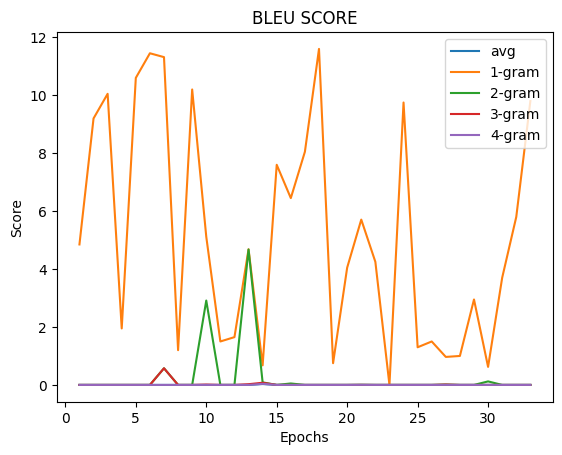

In [72]:
# 訓練模型
for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    bleu_scores = []

    start_time = time.time()
    train_loss = train(path='{}/MODELS/translation_model({}).pth'.format(dir_path,model_name))
    #break
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Train Time: {epoch_mins}m {epoch_secs}s')

    start_time = time.time()
    test_loss = evaluate()

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Test Time: {epoch_mins}m {epoch_secs}s')

    start_time = time.time()

    samples = get_samples(TEST_ZSENT,TEST_KSENT)
    test_score = sacrebleu_score(model, source_sentences=samples['zh'],target_sentences=samples['ko'])
    #test_score = sacrebleu_score(model, source_sentences=TEST_ZSENT,target_sentences=TEST_KSENT,bpmf_sentences=TEST_ZYSENT,hanja_sentences=TEST_HSENT)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Eval Time: {epoch_mins}m {epoch_secs}s')
    
    print('\tTrain Loss: {:.3f} | Test Loss: {:.3f}'.format(train_loss, test_loss))
    print('\tBLEU Score:')
    for k in test_score.keys():
        print('\t\t{}: {:.3f}'.format(k,test_score[k]))
    #break
    #'''
    wandb.log({"Epoch_Train_loss": train_loss, 
               "Epoch_Test_loss": test_loss,
               'BLEU_score(avg)':test_score['avg'],
               '1-gram':test_score['1-gram'],
               '2-gram':test_score['2-gram'],
               '3-gram':test_score['3-gram'],
               '4-gram':test_score['4-gram']})#'''

    # 儲存訓練好的模型
    if(test_score['avg'] > avg_best_score):
    #if(test_loss < best_loss):
      best_score = avg_best_score['avg']
      best_loss = test_loss
      torch.save(model.state_dict(), '{}/MODELS/best_translation_model({}).pth'.format(dir_path,model_name))
      print('== save model ==')
        
    if(test_score['1-gram'] > best_score):
    #if(test_loss < best_loss):
      best_score = test_score['1-gram']
      best_loss = test_loss
      torch.save(model.state_dict(), '{}/MODELS/best_translation_model({}).pth'.format(dir_path,model_name))
      print('== save model ==')

    #break

    if(test_score['1-gram'] < 1):
      try:
        model.load_state_dict(torch.load('{}/MODELS/best_translation_model({}).pth'.format(dir_path,model_name)))
        print('='*5,'load best model','='*5)
      except:
        model = transformer.to(device)
          
        #'nothing'


    train_losses.append(train_loss)
    test_losses.append(test_loss)
    bleu_scores.append(test_score)

    loss_history(train_losses, test_losses, path=model_name, to_show=False)
    sacrebleu_history(bleu_scores, path=model_name, to_show=False)
wandb.finish()

In [ ]:
bleu_score(test_source_sentences,model,tokenizer,max_length,device)

In [ ]:
from sacrebleu.metrics import BLEU

def sacrebleu_score(source_sentences,target_sentences,lang='ko'):
  global zh_tokenizer, ko_tokenizer, model, max_length, device
  model.eval()
  bleu = BLEU()
  bleu.trg_lang = lang
  avg_score = {'avg':0,'1-gram':0,'2-gram':0,'3-gram':0,'4-gram':0}

  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(source_sentences)) as pbar:
    for i in range(len(source_sentences)):
        source_sentence = source_sentences[i]
        target_sentence = target_sentences[i]
        source_tokens = zh_tokenizer(source_sentence, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
        with torch.no_grad():
            output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
        generated_sentence = ko_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
        gen_sent = ''
        for sent in generated_sentence:
            gen_sent += sent
        bleu_score = bleu.corpus_score([gen_sent],[[target_sentence]])
        #print([gen_sent],[[target_sentence]])
        #print(bleu_score)
        avg_score['avg'] += bleu_score.score
        avg_score['1-gram'] += bleu_score.precisions[0]
        avg_score['2-gram'] += bleu_score.precisions[1]
        avg_score['3-gram'] += bleu_score.precisions[2]
        avg_score['4-gram'] += bleu_score.precisions[3]
        pbar.update(1)
  avg_score['avg'] /= len(source_sentences)
  avg_score['1-gram'] /= len(source_sentences)
  avg_score['2-gram'] /= len(source_sentences)
  avg_score['3-gram'] /= len(source_sentences)
  avg_score['4-gram'] /= len(source_sentences)

  #print('gen:',generated_sentences,'tar:',[[sent] for sent in target_sentences],'sor',source_sentences)
  #print('BLEU Score:',bleu.score)

  return avg_score

In [ ]:
train_score = sacrebleu_score(TRAIN_ZSENT,TRAIN_KSENT)
test_score = sacrebleu_score(TEST_ZSENT,TEST_KSENT)
print('Train:',train_score)
print('Test:',test_score)